In [1]:
import os
import hydra
from omegaconf import DictConfig, OmegaConf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from qdax_bench.tasks.bbob.bbob_fns import fn_names_short_dict

Matplotlib created a temporary cache directory at /tmp/matplotlib-94h6lk_q because the default path (/home_nfs/paul/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
font_size = 24
params = {
    "axes.labelsize": font_size,
    "axes.titlesize": font_size,
    "legend.fontsize": font_size,
    "xtick.labelsize": font_size,
    "ytick.labelsize": font_size,
    "figure.titlesize": font_size + 2,
    "text.usetex": False,
    "axes.titlepad": 10,
}

mpl.rcParams.update(params)

In [3]:
path = "sweep/2025-06-30_123222_215804"
path = "/home_nfs/paul/dev/QDax_ES/sweep/2025-07-01_215431_824763"

folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]

In [4]:
def get_from_cfg(cfg: DictConfig, field: str):
    """Get a value from a DictConfig using a dot-separated field."""
    keys = field.split('.')
    value = cfg
    for key in keys:
        value = value.get(key)
    return value

In [5]:
cfg_path = f"{path}/{folders[0]}/.hydra/config.yaml"
# open with omegaconf
cfg = OmegaConf.load(cfg_path)

In [6]:
figure_field = "task.plotting.task_name"
plot_field = "algo.plotting.algo_name"
max_eval = 1e5

Found 8 tasks: attractive_sector 20D, bueche_rastrigin 20D, ellipsoidal 20D, linear_slope 20D, rastrigin 20D, rosenbrock 20D, sphere 20D, step_ellipsoidal 20D


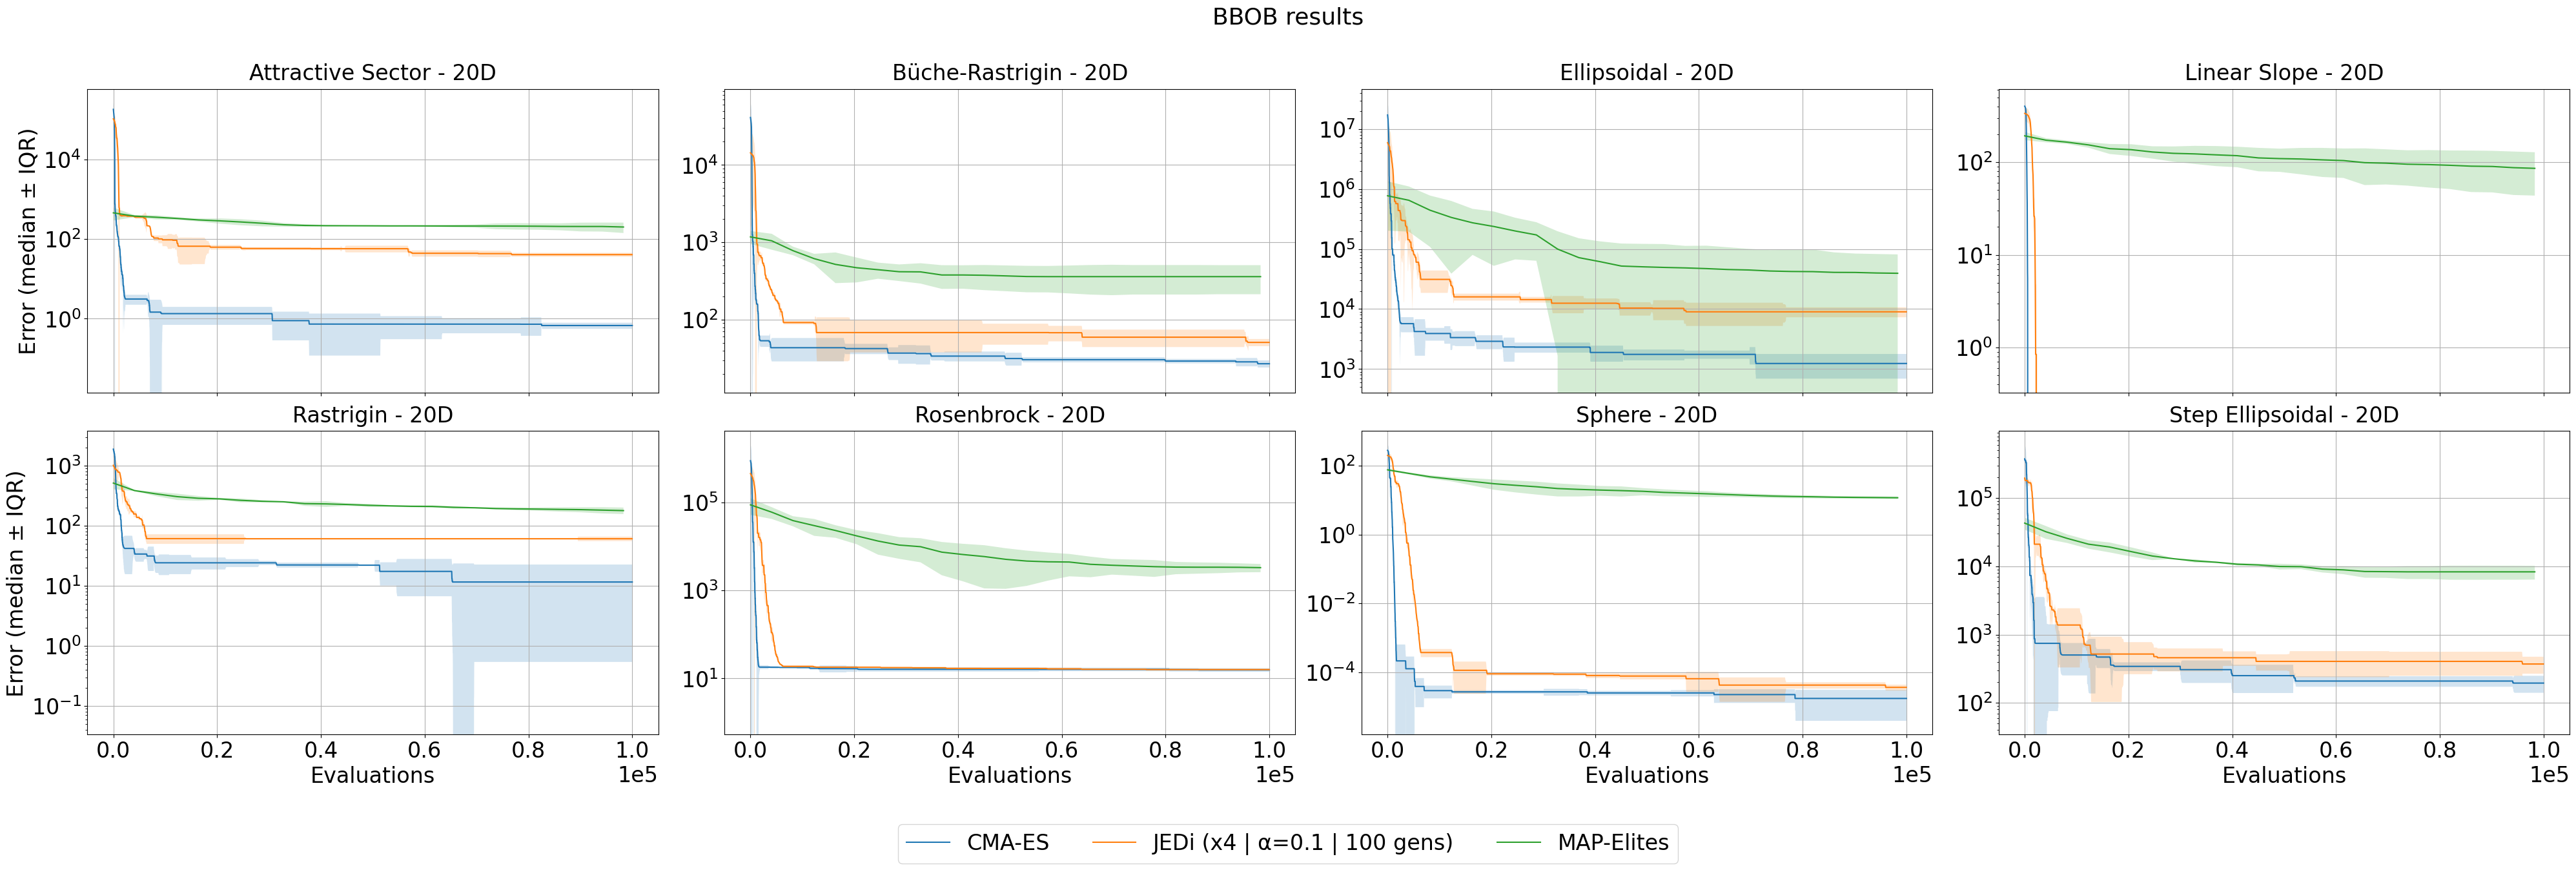

In [7]:
df = []
for folder in folders:
    cfg_path = f"{path}/{folder}/.hydra/config.yaml"
    cfg = OmegaConf.load(cfg_path)
    
    figure_name = get_from_cfg(cfg, figure_field)
    plot_name = get_from_cfg(cfg, plot_field)
    
    df.append({
        "figure": figure_name,
        "plot": plot_name,
        "folder": folder
    })

df = pd.DataFrame(df)
# group by figure 
fig_groups = df.groupby("figure")
print(f"Found {len(fig_groups)} tasks: {', '.join(fig_groups.groups.keys())}")

n_plots = len(fig_groups)

# Make a rectangle of subplots
n_col = 4
n_rows = n_plots // n_col + (n_plots % n_col > 0)

fig, axs = plt.subplots(n_rows, n_col, figsize=(10 * n_col, 6 * n_rows), sharex=True, sharey=False)
axs = axs.flatten()

for (figure_name, group), ax in zip(fig_groups, axs):
    plot_groups = group.groupby("plot")
    
    for plot_name, plot_group in plot_groups:
        runs = None
        for folder in plot_group['folder'].values:
            file_path = f"{path}/{folder}/mapelites-logs.csv"
            
            if os.path.exists(file_path):
                metrics_df = pd.read_csv(file_path)
                if runs is None:
                    runs = metrics_df[['evaluations', 'max_fitness']].copy()
                else:
                    runs = pd.merge(
                        runs, 
                        metrics_df[['evaluations', 'max_fitness']], 
                        on='evaluations', 
                        how='outer',
                        suffixes=('', f'_{folder}')
                    )
            else:
                print(f"File {file_path} does not exist.")
        if runs is not None:
            # Get median, IQR of all max_fitness columns
            max_fitness_cols = [col for col in runs.columns if col.startswith('max_fitness')]
            # fillna: take previous value if NaN
            runs[max_fitness_cols] = runs[max_fitness_cols].ffill()
            runs['median'] = runs[max_fitness_cols].median(axis=1)
            runs['iqr'] = runs[max_fitness_cols].quantile(0.75, axis=1) - runs[max_fitness_cols].quantile(0.25, axis=1)
            runs = runs[runs['evaluations'] <= max_eval]
            
            ax.plot(runs['evaluations'], -runs['median'], label=plot_name)
            # Plot the IQR as a shaded area
            ax.fill_between(
                runs['evaluations'], 
                -runs['median'] - runs['iqr'], 
                -runs['median'] + runs['iqr'], 
                alpha=0.2,
            )

    name, dim = figure_name.strip().split(' ')
    label = fn_names_short_dict.get(name, name)
    label = f"{label} - {dim}"
    ax.set_title(f"{label}")
    
    ax.set_yscale('log')
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    ax.grid(True)

    # ax.set_xlabel("Evaluations")
# Last row: set x-labels
for ax in axs[-n_col:]:
    ax.set_xlabel("Evaluations")
# First column: set y-labels
for i in range(n_rows):
    axs[i * n_col].set_ylabel("Error (median ± IQR)")
fig.suptitle("BBOB results", fontsize=font_size + 2, y=1.02)

# Add legend below the plots
handles, labels = axs[0].get_legend_handles_labels()
labels = [n.replace('_', '-') for n in labels]  # Format legend labels
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.1), fontsize=font_size)
fig.tight_layout()
plt.show()